In [1]:
import os.path as op
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS

import mne
from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories

In [2]:
print(__doc__)

data_path = visual_92_categories.data_path()

# Define stimulus - trigger mapping
fname = op.join(data_path, 'visual_stimuli.csv')
conds = read_csv(fname)
print(conds.head(5))

Automatically created module for IPython interactive environment
   trigger       condition  human  face  animal  natural
0        0  human bodypart      1     0       1        1
1        1  human bodypart      1     0       1        1
2        2  human bodypart      1     0       1        1
3        3  human bodypart      1     0       1        1
4        4  human bodypart      1     0       1        1


In [3]:
max_trigger = 92
conds = conds[:max_trigger]  # take only the first 24 rows

In [4]:
conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))
print(conditions[:5])

['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', '3/human bodypart/human/not-face/animal/natural', '4/human bodypart/human/not-face/animal/natural']


In [5]:
event_id = dict(zip(conditions, conds.trigger + 1))
event_id['0/human bodypart/human/not-face/animal/natural']

1

In [6]:
n_runs = 4  # 4 for full data (use less to speed up computations)
fname = op.join(data_path, 'sample_subject_%i_tsss_mc.fif')
raws = [read_raw_fif(fname % block, verbose='error')
        for block in range(n_runs)]  # ignore filename warnings
raw = concatenate_raws(raws)

events = mne.find_events(raw, min_duration=.002)
events = events[events[:, 2] <= max_trigger]

4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


In [7]:
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.800, preload=True)

Not setting metadata
Not setting metadata
2760 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2760 events and 901 original time points ...
2 bad epochs dropped


In [8]:
Q = epochs.copy().crop(0.05, 0.7).get_data()

In [9]:
Q.shape

(2758, 306, 651)

In [103]:
#Morlet Wavelet
myfreqrange = np.array([2,120])
Fs = 1000; # Hz, sampling rate
#timedur = Q.shape[2]/Fs; % seconds, temporal duration
timevec = np.arange(0.05, 0.7 + 1/Fs, 1/Fs); # vector of time between 0 and timedur seconds
timevec_gauss = np.arange(-2, 2, (1/Fs));
lofreq = myfreqrange[0];
hifreq = myfreqrange[1];

In [104]:
NWavelets = 400;
NCycles = 7;
MyFreqs = np.linspace(lofreq,hifreq,NWavelets);
MyMorletFamily = np.empty((0,4000), int)
MEG_Power = []
MEG_Power_Bands = []

In [105]:
def normpdf(x, mu=0, sigma=1):
    u = float((x-mu) / abs(sigma))
    y = np.exp(-u*u/2) / (np.sqrt(2*np.pi) * abs(sigma))
    return y

for wnum in range(0, NWavelets):
        myomega = 2 * np.pi * MyFreqs[wnum];
        mysigma = NCycles/myomega;
        mygauss = np.array([normpdf(i,0,mysigma)
                    for i in timevec_gauss]);
        mySig = np.exp(1j*myomega*timevec_gauss);
        MyMorletFamily = np.append(MyMorletFamily, [mySig * mygauss], axis = 0);

(400, 4000)

In [70]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.
clf = make_pipeline(StandardScaler(),
                    LogisticRegression(C=1, solver='liblinear',
                                       multi_class='auto'))
X = Q
#y = epochs.events[:, 2]
y_sup = (epochs.events[:, 2] > 48).astype(int)
classes = set(y_sup)

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

# Compute confusion matrix for each cross-validation fold
y_pred = np.zeros((len(y_sup), len(classes)))
for train, test in cv.split(X, y_sup):
    # Fit
    clf.fit(X[train], y_sup[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict_proba(X[test])

In [90]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y_sup == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]
confusion  

array([[0.67340695, 0.32659305],
       [0.32659305, 0.67340695]])

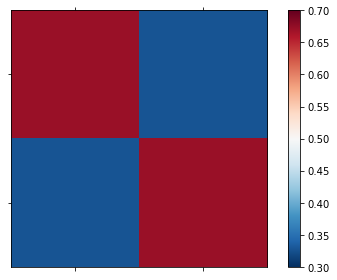

In [72]:
labels = [''] * 5 + ['face'] + [''] * 11 + ['bodypart'] + [''] * 6
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(11.5, color='k')
ax.axvline(11.5, color='k')
plt.colorbar(im)
plt.tight_layout()
plt.show()

IndexError: index 12 is out of bounds for axis 0 with size 2

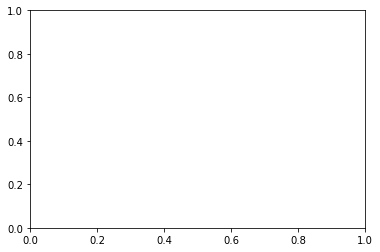

In [69]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity='precomputed')
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.get_cmap('rainbow')
colors = ['r', 'b']
names = list(conds['condition'].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == 'human face' else 100
    ax.scatter(summary[sel, 0], summary[sel, 1], s=size,
               facecolors=color, label=name, edgecolors='k')
ax.axis('off')
ax.legend(loc='lower right', scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()